In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys

In [3]:
import STAGATE

Reading Data

In [4]:
file = r'C:\Users\AGNISH\Desktop\IITK\VSCode\STAGATE\Landau\SPOTS Landau paper dataset\spleen_rep_1'
adata = sc.read_visium(file, count_file=r'GSE198353_spleen_rep_1_filtered_feature_bc_matrix.h5',load_images=True)
adata.var_names_make_unique()

In [5]:
file_fold = 'C:/Users/AGNISH/Desktop/IITK/VSCode/SpatialGlue/Data/Mouse_Spleen/'
gdata = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
gdata.var_names_make_unique()

In [6]:
gdata

AnnData object with n_obs × n_vars = 2653 × 32285
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [7]:
file_fold = 'C:/Users/AGNISH/Desktop/IITK/VSCode/SpatialGlue/Data/Mouse_Spleen/'
pdata = sc.read_h5ad(file_fold + 'adata_Pro.h5ad')
pdata.var_names_make_unique()

In [8]:
pdata

AnnData object with n_obs × n_vars = 2653 × 21
    obsm: 'spatial'

In [9]:
# gdata.obs=adata.obs
# pdata.obs=adata.obs
gdata.obsm=adata.obsm
gdata.uns = adata.uns
pdata.obsm=adata.obsm
pdata.uns = adata.uns

In [10]:
#Normalization
sc.pp.highly_variable_genes(gdata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(gdata, target_sum=1e4)
sc.pp.log1p(gdata)

In [11]:
#Normalization
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
#sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

In [12]:
gdata

AnnData object with n_obs × n_vars = 2653 × 32285
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'

In [13]:
pdata

AnnData object with n_obs × n_vars = 2653 × 21
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'

Model

In [14]:
!pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\agnish\.conda\envs\stagate\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [15]:
import tensorflow as tf
import tensorflow.compat.v1 as v1


class GATE():
    def __init__(self, hidden_dims1, hidden_dims2,z_dim=30,alpha=0, nonlinear=True, weight_decay=0.0001):
        self.n_layers1 = len(hidden_dims1) - 1
        self.n_layers2 = len(hidden_dims2) - 1
        self.alpha = alpha
        self.W1, self.v1, self.prune_v1 = self.define_weights1(hidden_dims1, self.n_layers1)
        self.W2, self.v2, self.prune_v2 = self.define_weights2(hidden_dims2, self.n_layers2)
        self.C1 = {}
        self.C2 = {}
        self.prune_C1 = {}
        self.prune_C2 = {}
        self.nonlinear = nonlinear
        self.weight_decay = weight_decay
        self.z_dim = z_dim

        # Decoder 1
        self.W_dec1 = {}
        for layer in range(self.n_layers1 - 1, -1, -1):
            self.W_dec1[layer] = tf.Variable(tf.random.normal([hidden_dims1[layer+1], hidden_dims1[layer]]))

        # Decoder 2
        self.W_dec2 = {}
        for layer in range(self.n_layers2 - 1, -1, -1):
            self.W_dec2[layer] = tf.Variable(tf.random.normal([hidden_dims2[layer+1], hidden_dims2[layer]]))

    def __call__(self, A1,A2 ,prune_A, X1,X2):
        # Encoder 1
        H1 = X1
        for layer in range(self.n_layers1):
            H1 = self.__encoder1(A1, prune_A, H1, layer)
            if self.nonlinear:
                if layer != self.n_layers1 - 1:
                    H1 = tf.nn.elu(H1)

        # Encoder 2
        H2 = X2
        for layer in range(self.n_layers2):
            H2 = self.__encoder2(A2, prune_A, H2, layer)
            if self.nonlinear:
                if layer != self.n_layers2 - 1:
                    H2 = tf.nn.elu(H2)
        # Concatenate encoder outputs
        H = tf.concat([H1, H2], axis=1)

        # Call the third encoder
        global latent_rep 
        H = self.__encoder3(H)
        
        latent_rep = H

        temp=H
        H1=temp
        # Decoder 1
        for layer in range(self.n_layers1 - 1, -1, -1):
            H1 = self.__decoder1(H1, layer)
            if self.nonlinear:
                if layer != 0:
                    H1 = tf.nn.elu(H1)
        X1_ = H1

        H2=temp
        # Decoder 2
        for layer1 in range(self.n_layers2 - 1, -1, -1):
            H2 = self.__decoder2(H2, layer1)
            if self.nonlinear:
                if layer1 != 0:
                    H2 = tf.nn.elu(H2)
        X2_ = H2

        # Loss calculation
        features_loss = tf.sqrt(tf.reduce_sum(tf.pow(X1 - X1_, 2)))
        features_loss += tf.sqrt(tf.reduce_sum(tf.pow(X2 - X2_, 2)))

        weight_decay_loss = 0
        for layer in range(self.n_layers1):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W1[layer]), self.weight_decay, name='weight_loss')
        for layer in range(self.n_layers2):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W2[layer]), self.weight_decay, name='weight_loss')
        for layer in range(self.n_layers1):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W_dec1[layer]), self.weight_decay, name='weight_loss')
        for layer in range(self.n_layers2):
            weight_decay_loss += tf.multiply(tf.nn.l2_loss(self.W_dec2[layer]), self.weight_decay, name='weight_loss')

        # Total loss
        self.loss = features_loss + weight_decay_loss

        if self.alpha == 0:
            self.Att_l = {'C1': self.C1, 'C2': self.C2}
        else:
            self.Att_l = {'C1': self.C1, 'C2': self.C2, 'prune_C1': self.prune_C1, 'prune_C2': self.prune_C2}
        return self.loss, latent_rep, self.Att_l, X1_, X2_
    
    def __encoder1(self, A, prune_A, H, layer):
        print('enc1 = ',H)
        H = tf.matmul(H, self.W1[layer])
        if layer == self.n_layers1 - 1:
            return H
        self.C1[layer] = self.graph_attention_layer(A, H, self.v1[layer], layer)
        if self.alpha == 0:
            return tf.sparse.sparse_dense_matmul(self.C1[layer], H)
        else:
            self.prune_C1[layer] = self.graph_attention_layer(prune_A, H, self.prune_v1[layer], layer)
            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C1[layer], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C1[layer], H)
        
        

    def __encoder2(self, A, prune_A, H, layer):
        print('enc2 = ',H)
        H = tf.matmul(H, self.W2[layer])
        if layer == self.n_layers2 - 1:
            return H
        self.C2[layer] = self.graph_attention_layer(A, H, self.v2[layer], layer)
        if self.alpha == 0:
            return tf.sparse.sparse_dense_matmul(self.C2[layer], H)
        else:
            self.prune_C2[layer] = self.graph_attention_layer(prune_A, H, self.prune_v2[layer], layer)
            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C2[layer], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C2[layer], H)
    
    def __decoder1(self, H, layer):
        print('dec1 = ',H)
        H = tf.matmul(H, self.W1[layer], transpose_b=True)
        if layer == 0:

            return H
        if self.alpha == 0:

            return tf.sparse.sparse_dense_matmul(self.C1[layer-1], H)
        else:

            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C1[layer-1], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C1[layer-1], H)
        
    def __decoder2(self, H, layer):
        print('dec2 = ',H)
        H = tf.matmul(H, self.W2[layer], transpose_b=True)
        if layer == 0:

            return H
        if self.alpha == 0:
            return tf.sparse.sparse_dense_matmul(self.C2[layer-1], H)
        
        else:

            return (1 - self.alpha) * tf.sparse.sparse_dense_matmul(self.C2[layer-1], H) + self.alpha * tf.sparse.sparse_dense_matmul(
                self.prune_C2[layer-1], H)
        

    def __encoder3(self, H):
        print('enc3 = ', H)
        input_dim = H.shape[-1]
        output_dim = self.z_dim

        # Define the weights and bias
        weights = tf.Variable(tf.random.normal(shape=(input_dim, output_dim)))
        bias = tf.Variable(tf.zeros(shape=(output_dim,)))

        # Perform the matrix multiplication and add the bias
        H = tf.matmul(H, weights) + bias

        print('LATENT = ', H)
        return H


    def define_weights1(self,hidden_dims,n_layers):
        W = {}
        #print('TOTAL LEYRS = ',n_layers)
        #n_layers=len(n_layers)-1
        print('n_layers gene = ',n_layers)
        print('Hidden dim gene = ',hidden_dims)

        for i in range(n_layers):
            W[i] = v1.get_variable("W%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

        Ws_att = {}
        for i in range(n_layers-1):
            V= {}
            V[0] = v1.get_variable("V%s_0" % i, shape=(hidden_dims[i+1], 1))
            V[1] = v1.get_variable("V%s_1" % i, shape=(hidden_dims[i+1], 1))

            Ws_att[i] = V
        if self.alpha == 0:
            return W, Ws_att, None
        prune_Ws_att = {}
        for i in range(n_layers-1):
            prune_V = {}
            prune_V[0] = v1.get_variable("prune_V%s_0" % i, shape=(hidden_dims[i+1], 1))
            prune_V[1] = v1.get_variable("prune_V%s_1" % i, shape=(hidden_dims[i+1], 1))

            prune_Ws_att[i] = prune_V

        return W, Ws_att, prune_Ws_att
    
    def define_weights2(self,hidden_dims,n_layers):
        w = {}
        #print('TOTAL LEYRS = ',n_layers)
        #n_layers=len(n_layers)-1
        print('n_layers protein = ',n_layers)
        print('Hidden dim protein = ',hidden_dims)

        for i in range(n_layers):
            w[i] = v1.get_variable("w%s" % i, shape=(hidden_dims[i], hidden_dims[i+1]))

        ws_att = {}
        for i in range(n_layers-1):
            v = {}
            v[0] = v1.get_variable("v%s_0" % i, shape=(hidden_dims[i+1], 1))
            v[1] = v1.get_variable("v%s_1" % i, shape=(hidden_dims[i+1], 1))

            ws_att[i] = v
        if self.alpha == 0:
            return w, ws_att, None
        prune_ws_att = {}
        for i in range(n_layers-1):
            prune_v = {}
            prune_v[0] = v1.get_variable("prune_v%s_0" % i, shape=(hidden_dims[i+1], 1))
            prune_v[1] = v1.get_variable("prune_v%s_1" % i, shape=(hidden_dims[i+1], 1))

            prune_ws_att[i] = prune_v

        return w, ws_att, prune_ws_att
    


    def graph_attention_layer(self, A, M, v, layer):

        with v1.variable_scope("layer_%s" % layer):
            f1 = tf.matmul(M, v[0])
            f1 = A * f1
            f2 = tf.matmul(M, v[1])
            f2 = A * tf.transpose(f2, [1, 0])
            logits = v1.sparse_add(f1, f2)

            unnormalized_attentions = tf.SparseTensor(indices=logits.indices,
                                         values=tf.nn.sigmoid(logits.values),
                                         dense_shape=logits.dense_shape)
            attentions = v1.sparse_softmax(unnormalized_attentions)

            attentions = tf.SparseTensor(indices=attentions.indices,
                                         values=attentions.values,
                                         dense_shape=attentions.dense_shape)

            return attentions

In [16]:
import tensorflow as tf
import scipy.sparse as sp
import numpy as np
#from .model import GATE
import tensorflow.compat.v1 as v1
from tqdm import tqdm

class STAGATE():

    def __init__(self, hidden_dims1, hidden_dims2,z_dim=30, alpha=0, n_epochs=500, lr=0.0001, 
                 gradient_clipping=5, nonlinear=True, weight_decay=0.0001, 
                 verbose=True, random_seed=2020,
                 ):
        
        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)
        self.loss_list = []
        self.lr = lr
        self.n_epochs = n_epochs
        self.gradient_clipping = gradient_clipping
        self.build_placeholders()
        self.verbose = verbose
        self.alpha = alpha
           

        self.gate = GATE(hidden_dims1,hidden_dims2,z_dim,alpha, nonlinear, weight_decay)
        self.loss, self.H, self.C, self.ReX1, self.ReX2 = self.gate(self.A1,self.A2, self.prune_A, self.X1,self.X2)
        #print(self.loss, self.H, self.C, self.ReX1, self.ReX2,sep='\n')

        self.optimize(self.loss)
        self.build_session()

    def build_placeholders(self):
        self.A1 = v1.sparse_placeholder(dtype=tf.float32)
        self.A2 = v1.sparse_placeholder(dtype=tf.float32)
        self.prune_A = v1.sparse_placeholder(dtype=tf.float32)
        self.X1 = v1.placeholder(dtype=tf.float32)
        self.X2 = v1.placeholder(dtype=tf.float32)


    def build_session(self, gpu= True):
        config = v1.ConfigProto()
        config.gpu_options.allow_growth = True
        if gpu == False:
            config.intra_op_parallelism_threads = 0
            config.inter_op_parallelism_threads = 0
        self.session = v1.Session(config=config)
        self.session.run([v1.global_variables_initializer(), v1.local_variables_initializer()])

    def optimize(self, loss):
        optimizer = v1.train.AdamOptimizer(learning_rate=self.lr)
        gradients, variables = zip(*optimizer.compute_gradients(loss))
        gradients, _ = tf.clip_by_global_norm(gradients, self.gradient_clipping)
        self.train_op = optimizer.apply_gradients(zip(gradients, variables))

    def __call__(self, A1, A2, prune_A, X1, X2):
        for epoch in range(self.n_epochs):
            self.run_epoch(epoch, A1, A2, prune_A, X1, X2)




    def run_epoch(self, epoch, A1,A2 ,prune_A, X1,X2):

        loss, _ = self.session.run([self.loss, self.train_op],
                           feed_dict={self.A1: A1,
                                      self.A2: A2,
                                      self.prune_A: prune_A,
                                      self.X1: X1,
                                      self.X2: X2})

        self.loss_list.append(loss)
        if self.verbose:
            print("Epoch: %s, Loss: %.4f" % (epoch, loss))
            
        return loss

    def infer(self, A1,A2, prune_A, X1,X2):
        global C
        H, C, ReX1, ReX2 = self.session.run([self.H, self.C, self.ReX1, self.ReX2],
                                    feed_dict={self.A1: A1,
                                               self.A2: A2,
                                               self.prune_A: prune_A,
                                               self.X1: X1,
                                               self.X2: X2})

        
        return H, self.Conbine_Atten_l(C['C1']), self.loss_list, ReX1,ReX2

    def Conbine_Atten_l(self, input):
        if self.alpha == 0:
            return [sp.coo_matrix((input[layer][1], (input[layer][0][:, 0], input[layer][0][:, 1])), shape=(input[layer][2][0], input[layer][2][1])) for layer in input]
        else:
            Att_C = [sp.coo_matrix((input['C'][layer][1], (input['C'][layer][0][:, 0], input['C'][layer][0][:, 1])), shape=(input['C'][layer][2][0], input['C'][layer][2][1])) for layer in input['C']]
            Att_pruneC = [sp.coo_matrix((input['prune_C'][layer][1], (input['prune_C'][layer][0][:, 0], input['prune_C'][layer][0][:, 1])), shape=(input['prune_C'][layer][2][0], input['prune_C'][layer][2][1])) for layer in input['prune_C']]
            return [self.alpha*Att_pruneC[layer] + (1-self.alpha)*Att_C[layer] for layer in input['C']]

In [17]:
import numpy as np
import scipy.sparse as sp
#from .STAGATE import STAGATE
import tensorflow as tf
import pandas as pd
import scanpy as sc

def train_STAGATE(adata1,adata2, 
                hidden_dims1=[512, 30],hidden_dims2=[512, 30],z_dim=30, alpha=0, n_epochs=500, lr=0.0001, key_added='MY_ARCH',
                gradient_clipping=5, nonlinear=True, weight_decay=0.0001,verbose=True, 
                random_seed=2020, pre_labels=None, pre_resolution=0.2,
                save_attention=False, save_loss=False, save_reconstrction=False
                ):
    """\
    Training graph attention auto-encoder.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    hidden_dims
        The dimension of the encoder.
    alpha
        The weight of cell type-aware spatial neighbor network.
    n_epochs
        Number of total epochs in training.
    lr
        Learning rate for AdamOptimizer.
    key_added
        The latent embeddings are saved in adata.obsm[key_added].
    gradient_clipping
        Gradient Clipping.
    nonlinear
        If True, the nonlinear avtivation is performed.
    weight_decay
        Weight decay for AdamOptimizer.
    pre_labels
        The key in adata.obs for the manually designate the pre-clustering results. Only used when alpha>0.
    pre_resolution
        The resolution parameter of sc.tl.louvain for the pre-clustering. Only used when alpha>0 and per_labels==None.
    save_attention
        If True, the weights of the attention layers are saved in adata.uns['STAGATE_attention']
    save_loss
        If True, the training loss is saved in adata.uns['STAGATE_loss'].
    save_reconstrction
        If True, the reconstructed expression profiles are saved in adata.layers['STAGATE_ReX'].

    Returns
    -------
    AnnData
    """

    #tf.reset_default_graph()
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    if 'highly_variable' in adata1.var.columns:
        adata_Vars1 =  adata1[:, adata1.var['highly_variable']]
    else:
        adata_Vars1 = adata1
    X1 = pd.DataFrame(adata_Vars1.X[:, ].toarray(), index=adata_Vars1.obs.index, columns=adata_Vars1.var.index)

    
    if 'highly_variable' in adata2.var.columns:
        adata_Vars2 =  adata2[:, adata2.var['highly_variable']]
    else:
        adata_Vars2 = adata2
    X2 = pd.DataFrame(adata_Vars2.X[:, ], index=adata_Vars2.obs.index, columns=adata_Vars2.var.index)

    if verbose:
        print('Size of Input for gene data : ', adata_Vars1.shape)
        print('Size of Input for protein data : ',adata_Vars2.shape)



    cells1 = np.array(X1.index)
    cells_id_tran1 = dict(zip(cells1, range(cells1.shape[0])))
    if 'Spatial_Net' not in adata1.uns.keys():
        raise ValueError("Spatial_Net is not existed! Run Cal_Spatial_Net first!")

    Spatial_Net1 = adata1.uns['Spatial_Net']
    G_df1 = Spatial_Net1.copy()
    G_df1['Cell1'] = G_df1['Cell1'].map(cells_id_tran1)
    G_df1['Cell2'] = G_df1['Cell2'].map(cells_id_tran1)
    G1 = sp.coo_matrix((np.ones(G_df1.shape[0]), (G_df1['Cell1'], G_df1['Cell2'])), shape=(adata1.n_obs, adata1.n_obs))
    global G_tf1
    G_tf1 = prepare_graph_data(G1)

    cells2 = np.array(X2.index)
    cells_id_tran2 = dict(zip(cells2, range(cells2.shape[0])))
    if 'Spatial_Net' not in adata2.uns.keys():
        raise ValueError("Spatial_Net is not existed! Run Cal_Spatial_Net first!")
    Spatial_Net2 = adata1.uns['Spatial_Net']
    G_df2 = Spatial_Net2.copy()
    G_df2['Cell1'] = G_df2['Cell1'].map(cells_id_tran2)
    G_df2['Cell2'] = G_df2['Cell2'].map(cells_id_tran2)
    G2 = sp.coo_matrix((np.ones(G_df2.shape[0]), (G_df2['Cell1'], G_df2['Cell2'])), shape=(adata2.n_obs, adata2.n_obs))
    global G_tf2
    G_tf2 = prepare_graph_data(G2)

    tf.compat.v1.disable_eager_execution()
    trainer = STAGATE(hidden_dims1=[X1.shape[1]] + hidden_dims1,hidden_dims2=[X2.shape[1]] + hidden_dims2, z_dim=z_dim,alpha=alpha, 
                    n_epochs=n_epochs, lr=lr, gradient_clipping=gradient_clipping, 
                    nonlinear=nonlinear,weight_decay=weight_decay, verbose=verbose, 
                    random_seed=random_seed                    
                    )
    

    print("START TRAIN")
    
    #explain the code from here
    if alpha == 0:
        trainer(G_tf1, G_tf2, G_tf1, X1,X2)
        embeddings, attentions, loss, ReX1, ReX2= trainer.infer(G_tf1, G_tf2, G_tf1, X1,X2)
    else:
        G_df1 = Spatial_Net1.copy()
        if pre_labels==None:
            if verbose:
                print('------Pre-clustering adata1 using louvain with resolution=%.2f' %pre_resolution)
            sc.tl.pca(adata1, svd_solver='arpack')
            sc.pp.neighbors(adata1)
            sc.tl.louvain(adata1, resolution=pre_resolution, key_added='expression_louvain_label')
            pre_labels = 'expression_louvain_label'
        prune_G_df = prune_spatial_Net(G_df1, adata1.obs[pre_labels])
        prune_G_df['Cell1'] = prune_G_df['Cell1'].map(cells_id_tran1)
        prune_G_df['Cell2'] = prune_G_df['Cell2'].map(cells_id_tran1)
        prune_G = sp.coo_matrix((np.ones(prune_G_df.shape[0]), (prune_G_df['Cell1'], prune_G_df['Cell2'])))
        prune_G_tf = prepare_graph_data(prune_G)
        prune_G_tf = (prune_G_tf[0], prune_G_tf[1], G_tf1[2])
        trainer(G_tf1, prune_G_tf, X1)
        embeddings, attentions, loss, ReX1, ReX2 = trainer.infer(G_tf1,G_tf2, prune_G_tf, X1,X2)

    global df
    cell_reps = pd.DataFrame(embeddings)
    df=cell_reps
    cell_reps.index = cells1

    adata1.obsm[key_added] = cell_reps.loc[adata1.obs_names, ].values
    if save_attention:
        adata1.uns['arch_attention'] = attentions
    if save_loss:
        adata1.uns['arch_loss'] = loss
    if save_reconstrction:
        ReX1 = pd.DataFrame(ReX1, index=X1.index, columns=X1.columns)
        ReX1[ReX1<0] = 0
        adata1.layers['arch_ReX1'] = ReX1.values
        ReX2 = pd.DataFrame(ReX2, index=X2.index, columns=X2.columns)
        ReX2[ReX2<0] = 0
        adata2.layers['archE_ReX2'] = ReX2.values

    return adata1




def prune_spatial_Net(Graph_df, label):
    print('------Pruning the graph...')
    print('%d edges before pruning.' %Graph_df.shape[0])
    pro_labels_dict = dict(zip(list(label.index), label))
    Graph_df['Cell1_label'] = Graph_df['Cell1'].map(pro_labels_dict)
    Graph_df['Cell2_label'] = Graph_df['Cell2'].map(pro_labels_dict)
    Graph_df = Graph_df.loc[Graph_df['Cell1_label']==Graph_df['Cell2_label'],]
    print('%d edges after pruning.' %Graph_df.shape[0])
    return Graph_df


def prepare_graph_data(adj):
    # adapted from preprocess_adj_bias
    num_nodes = adj.shape[0]
    adj = adj + sp.eye(num_nodes)# self-loop
    #data =  adj.tocoo().data
    #adj[adj > 0.0] = 1.0
    if not sp.isspmatrix_coo(adj):
        adj = adj.tocoo()
    adj = adj.astype(np.float32)
    indices = np.vstack((adj.col, adj.row)).transpose()
    return (indices, adj.data, adj.shape)

def recovery_Imputed_Count(adata, size_factor):
    assert('ReX1' in adata.uns)
    temp_df = adata.uns['ReX1'].copy()
    sf = size_factor.loc[temp_df.index]
    temp_df = np.expm1(temp_df)
    temp_df = (temp_df.T * sf).T
    adata.uns['ReX_Count1'] = temp_df
    
    assert('ReX2' in adata.uns)
    temp_df = adata.uns['ReX2'].copy()
    sf = size_factor.loc[temp_df.index]
    temp_df = np.expm1(temp_df)
    temp_df = (temp_df.T * sf).T
    adata.uns['ReX_Count2'] = temp_df

    return adata

In [18]:
import pandas as pd
import numpy as np
import sklearn.neighbors


def Cal_Spatial_Net(adata, rad_cutoff=None, k_cutoff=None, model='Radius', verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff
        radius cutoff when model='Radius'
    k_cutoff
        The number of nearest neighbors when model='KNN'
    model
        The network construction model. When model=='Radius', the spot is connected to spots whose distance is less than rad_cutoff. When model=='KNN', the spot is connected to its first k_cutoff nearest neighbors.
    
    Returns
    -------
    The spatial networks are saved in adata.uns['Spatial_Net']
    """

    assert(model in ['Radius', 'KNN'])
    if verbose:
        print('------Calculating spatial graph...')
    coor = pd.DataFrame(adata.obsm['spatial'])
    coor.index = adata.obs.index
    coor.columns = ['imagerow', 'imagecol']

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_cutoff).fit(coor)
        distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices[it].shape[0], indices[it], distances[it])))
    
    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k_cutoff+1).fit(coor)
        distances, indices = nbrs.kneighbors(coor)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices.shape[1],indices[it,:], distances[it,:])))

    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_cell_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
    if verbose:
        print('The graph contains %d edges, %d cells.' %(Spatial_Net.shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %(Spatial_Net.shape[0]/adata.n_obs))

    adata.uns['Spatial_Net'] = Spatial_Net


def Cal_Spatial_Net_3D(adata, rad_cutoff_2D, rad_cutoff_Zaxis,
                       key_section='Section_id', section_order=None, verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff_2D
        radius cutoff for 2D SNN construction.
    rad_cutoff_Zaxis
        radius cutoff for 2D SNN construction for consturcting SNNs between adjacent sections.
    key_section
        The columns names of section_ID in adata.obs.
    section_order
        The order of sections. The SNNs between adjacent sections are constructed according to this order.
    
    Returns
    -------
    The 3D spatial networks are saved in adata.uns['Spatial_Net'].
    """
    adata.uns['Spatial_Net_2D'] = pd.DataFrame()
    adata.uns['Spatial_Net_Zaxis'] = pd.DataFrame()
    num_section = np.unique(adata.obs[key_section]).shape[0]
    if verbose:
        print('Radius used for 2D SNN:', rad_cutoff_2D)
        print('Radius used for SNN between sections:', rad_cutoff_Zaxis)
    for temp_section in np.unique(adata.obs[key_section]):
        if verbose:
            print('------Calculating 2D SNN of section ', temp_section)
        temp_adata = adata[adata.obs[key_section] == temp_section, ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_2D, verbose=False)
        temp_adata.uns['Spatial_Net']['SNN'] = temp_section
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_2D'] = pd.concat(
            [adata.uns['Spatial_Net_2D'], temp_adata.uns['Spatial_Net']])
    for it in range(num_section-1):
        section_1 = section_order[it]
        section_2 = section_order[it+1]
        if verbose:
            print('------Calculating SNN between adjacent section %s and %s.' %
                  (section_1, section_2))
        Z_Net_ID = section_1+'-'+section_2
        temp_adata = adata[adata.obs[key_section].isin(
            [section_1, section_2]), ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_Zaxis, verbose=False)
        spot_section_trans = dict(
            zip(temp_adata.obs.index, temp_adata.obs[key_section]))
        temp_adata.uns['Spatial_Net']['Section_id_1'] = temp_adata.uns['Spatial_Net']['Cell1'].map(
            spot_section_trans)
        temp_adata.uns['Spatial_Net']['Section_id_2'] = temp_adata.uns['Spatial_Net']['Cell2'].map(
            spot_section_trans)
        used_edge = temp_adata.uns['Spatial_Net'].apply(
            lambda x: x['Section_id_1'] != x['Section_id_2'], axis=1)
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[used_edge, ]
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[:, [
            'Cell1', 'Cell2', 'Distance']]
        temp_adata.uns['Spatial_Net']['SNN'] = Z_Net_ID
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_Zaxis'] = pd.concat(
            [adata.uns['Spatial_Net_Zaxis'], temp_adata.uns['Spatial_Net']])
    adata.uns['Spatial_Net'] = pd.concat(
        [adata.uns['Spatial_Net_2D'], adata.uns['Spatial_Net_Zaxis']])
    if verbose:
        print('3D SNN contains %d edges, %d cells.' %
            (adata.uns['Spatial_Net'].shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %
            (adata.uns['Spatial_Net'].shape[0]/adata.n_obs))

def Stats_Spatial_Net(adata):
    import matplotlib.pyplot as plt
    Num_edge = adata.uns['Spatial_Net']['Cell1'].shape[0]
    Mean_edge = Num_edge/adata.shape[0]
    plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
    plot_df = plot_df/adata.shape[0]
    fig, ax = plt.subplots(figsize=[3,2])
    plt.ylabel('Percentage')
    plt.xlabel('')
    plt.title('Number of Neighbors (Mean=%.2f)'%Mean_edge)
    ax.bar(plot_df.index, plot_df)

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='MY_ARCH', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

------Calculating spatial graph...


The graph contains 15482 edges, 2653 cells.
5.8357 neighbors per cell on average.


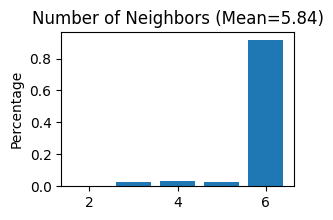

In [19]:
Cal_Spatial_Net(gdata, rad_cutoff=50)
Stats_Spatial_Net(gdata)

------Calculating spatial graph...
The graph contains 15482 edges, 2653 cells.
5.8357 neighbors per cell on average.


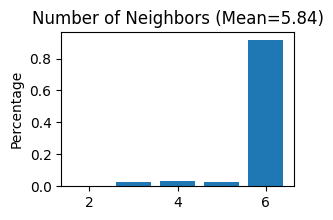

In [20]:
Cal_Spatial_Net(pdata, rad_cutoff=50)
Stats_Spatial_Net(pdata)

In [21]:
gdata = train_STAGATE(gdata,pdata,n_epochs=500,hidden_dims2=[128, 30], alpha=0)

Size of Input for gene data :  (2653, 3000)
Size of Input for protein data :  (2653, 21)
n_layers gene =  2
Hidden dim gene =  [3000, 512, 30]
n_layers protein =  2
Hidden dim protein =  [21, 128, 30]
enc1 =  Tensor("Placeholder_9:0", dtype=float32)
enc1 =  Tensor("Elu:0", shape=(None, None), dtype=float32)
enc2 =  Tensor("Placeholder_10:0", dtype=float32)
enc2 =  Tensor("Elu_1:0", shape=(None, None), dtype=float32)
enc3 =  Tensor("concat:0", shape=(None, 60), dtype=float32)
LATENT =  Tensor("add:0", shape=(None, 30), dtype=float32)
dec1 =  Tensor("add:0", shape=(None, 30), dtype=float32)
dec1 =  Tensor("Elu_2:0", shape=(None, 512), dtype=float32)
dec2 =  Tensor("add:0", shape=(None, 30), dtype=float32)
dec2 =  Tensor("Elu_3:0", shape=(None, 128), dtype=float32)
START TRAIN
Epoch: 0, Loss: 6091.1436
Epoch: 1, Loss: 5236.2993
Epoch: 2, Loss: 4579.7803
Epoch: 3, Loss: 4158.6538
Epoch: 4, Loss: 3913.2239
Epoch: 5, Loss: 3755.9570
Epoch: 6, Loss: 3622.4734
Epoch: 7, Loss: 3490.3748
Epoch: 

In [22]:
df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
AAACACCAATAACTGC-1,1.649343,-5.412395,-2.775347,18.243866,4.519862,0.354238,-10.308263,-3.765961,9.601871,-9.345468,...,-9.725111,11.775965,5.980098,13.755486,-9.700246,17.225306,7.483335,4.442431,-4.208684,6.151949
AAACAGAGCGACTCCT-1,1.134628,-3.597872,-2.199467,16.866619,4.877205,2.279237,-8.997834,-1.954935,7.726055,-9.942745,...,-8.531727,11.826932,6.909817,12.587914,-7.347322,16.512547,5.316182,5.448101,-3.633958,5.157310
AAACAGCTTTCAGAAG-1,1.780917,-4.376865,-2.354701,17.746420,6.619067,2.142900,-10.621325,-3.573757,11.001306,-9.283002,...,-10.494224,10.738111,6.569272,13.874000,-9.768857,18.868332,7.775961,4.736500,-2.880925,5.387755
AAACAGGGTCTATATT-1,1.535874,-6.241535,-2.903661,19.880102,5.693083,0.788247,-10.560435,-2.735912,11.693749,-10.745358,...,-11.180912,12.174528,6.083495,12.243327,-9.028637,18.780848,8.034453,5.862474,-3.163410,6.007352
AAACCACTACACAGAT-1,1.357293,-5.525475,-2.731970,16.243628,6.075887,-1.445754,-11.449165,-4.372645,11.828270,-9.211846,...,-10.956197,9.268101,7.289815,12.628864,-9.798765,18.101360,5.162263,2.195775,-1.285651,5.191287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,-0.019499,-4.829815,-2.626454,18.383753,4.784410,1.311969,-11.203422,-2.746394,10.667964,-10.337107,...,-10.132782,12.528727,7.998743,13.046653,-10.403415,18.117929,7.144433,7.582425,-2.523416,5.926888
TTGTTGTGTGTCAAGA-1,1.796033,-4.889400,-2.062124,17.578512,4.838607,2.566391,-9.023846,-1.175938,8.687899,-9.888668,...,-8.533532,12.130326,6.227304,12.206149,-7.429314,16.716766,6.124701,7.242953,-4.483486,5.826553
TTGTTTCACATCCAGG-1,1.930686,-6.601642,-4.199193,22.130644,4.412690,2.069037,-11.893485,-2.159453,8.680767,-12.292983,...,-11.826441,14.297534,5.678336,12.723120,-6.023280,18.476860,6.940201,8.990851,-3.382581,4.951330
TTGTTTCATTAGTCTA-1,1.048187,-5.704184,-3.917589,18.151850,4.461851,0.214557,-10.788285,-2.517375,12.197574,-10.714172,...,-10.000151,12.093121,5.696552,14.559952,-10.455192,18.138750,7.419641,5.593665,-1.883569,6.690540


In [23]:
# Write the 'data' variable to a file in CSV format
np.savetxt('data.csv', gdata.obsm['MY_ARCH'], delimiter=',')

In [24]:
gdata.obs

""
AAACACCAATAACTGC-1
AAACAGAGCGACTCCT-1
AAACAGCTTTCAGAAG-1
AAACAGGGTCTATATT-1
AAACCACTACACAGAT-1
...
TTGTTCAGTGTGCTAC-1
TTGTTGTGTGTCAAGA-1
TTGTTTCACATCCAGG-1
TTGTTTCATTAGTCTA-1


In [25]:
# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'C:/Users/AGNISH/.conda/envs/GraphST/Lib/R/'
mclust_R(gdata, num_cluster=4)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 2653 × 32285
    obs: 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'Spatial_Net'
    obsm: 'spatial', 'MY_ARCH'

In [26]:
sc.pp.neighbors(gdata, use_rep='MY_ARCH')
sc.tl.umap(gdata)

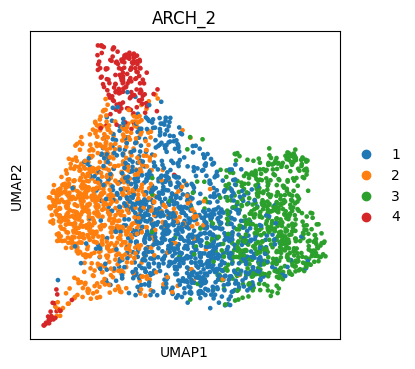

In [31]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(gdata, color=["mclust"], title=['ARCH_2'])

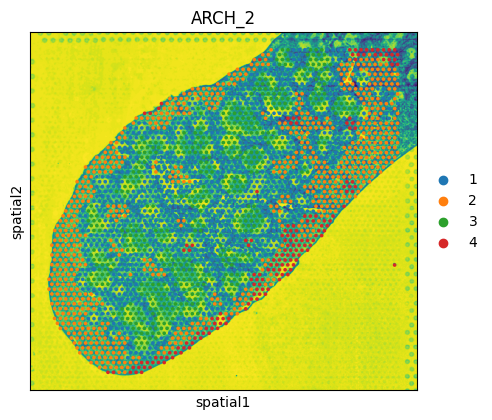

In [30]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(gdata, color=["mclust"], title=['ARCH_2'])